In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import grangercausalitytests

# Intitial overview and processing of the datasets

In [3]:
# Load data
commodity_prices = pd.read_excel('Data/Processed/DAILY_COMMODITY_PRICES.xlsx')
exchange_rates = pd.read_excel('Data/Processed/DAILY_EXCHANGE_RATES.xlsx')
stock_prices = pd.read_excel('Data/Processed/DAILY_STOCK_PRICES.xlsx')

In [4]:
commodity_prices.head()

,Date,Price,Change,% Change,Cumulative Change %,Ticker
0,2018-01-02,50.781433,20.599633,68.251837,68.251837,HHGAS-FDS
1,2018-01-03,50.641342,-0.140091,-0.275871,67.787680,HHGAS-FDS
2,2018-01-04,37.605713,-13.035629,-25.741081,24.597317,HHGAS-FDS
3,2018-01-05,37.438774,-0.166939,-0.443919,24.044205,HHGAS-FDS
4,2018-01-08,23.359003,-14.079771,-37.607457,-22.605666,HHGAS-FDS


In [5]:
exchange_rates.head()

,Date,Bid,Ask,Mid,Change,% Change,Cumulative Change %,High,Low,Ticker
0,2018-01-02,8.366927,8.374588,8.370757,-0.022962,-0.273562,-0.273562,8.370757,8.370757,CHFNOK
1,2018-01-03,8.301750,8.310708,8.306228,-0.064529,-0.770886,-1.042339,8.306228,8.306228,CHFNOK
2,2018-01-04,8.291795,8.301693,8.296742,-0.009486,-0.114203,-1.155352,8.296742,8.296742,CHFNOK
3,2018-01-05,8.250410,8.259255,8.254831,-0.041911,-0.505150,-1.654666,8.254831,8.254831,CHFNOK
4,2018-01-08,8.273807,8.283168,8.278486,0.023655,0.286559,-1.372848,8.278486,8.278486,CHFNOK


In [6]:
stock_prices.head()

,Date,Price,CVol,Change,% Change,% Return,Total Return (Gross),Cumulative Return %,Open,High,Low,Cumulative Change %,Ticker
0,2018-01-02,204.2,310003.0,2.3,1.139178,1.139178,204.2,1.139178,204.0,205.4,202.6,1.139178,AKERBP-NO
1,2018-01-03,207.0,303887.0,2.8,1.371205,1.371205,207.0,2.526003,205.0,207.0,204.0,2.526003,AKERBP-NO
2,2018-01-04,208.2,529411.0,1.2,0.579710,0.579710,208.2,3.120357,209.0,210.2,207.4,3.120357,AKERBP-NO
3,2018-01-05,209.6,473251.0,1.4,0.672430,0.672430,209.6,3.813769,208.0,211.4,207.4,3.813769,AKERBP-NO
4,2018-01-08,211.2,411438.0,1.6,0.763359,0.763359,211.2,4.606241,209.8,214.2,209.6,4.606241,AKERBP-NO


### Process stock price dataset

In [7]:
# Identiy the unique stock tickers
unique_stocks = stock_prices['Ticker'].unique()
print(unique_stocks)

['AKERBP-NO' 'YAR-NO' 'XOM' 'KOG-NO' 'DNO-NO' 'NHY-NO' 'EQNR-NO' '2222-SA'
 'VAR-NO' 'SHEL-GB' 'DOFG-NO']


In [24]:
# Dictionary to store separate stock dataframes
stock_dataframes = {}
for ticker in unique_stocks:
    df = stock_prices[stock_prices['Ticker'] == ticker].copy()
    df = df[['Date','% Return']]  # Keep only relevant columns
    df.columns = ['Date', 'Change_percent']  # Rename columns
    stock_dataframes[ticker] = df
    
# Check the dataframes
stock_dataframes['YAR-NO'].head()

,Date,Change_percent
1793,2018-01-02,0.637107
1794,2018-01-03,0.949610
1795,2018-01-04,-0.235174
1796,2018-01-05,0.942903
1797,2018-01-08,2.127668


<span style="color: red;">OBS! Exchange rate dataset stops one day ahead of the other datasets</span>


In [9]:
# Check alignment across datasets
print(commodity_prices['Date'].min(), commodity_prices['Date'].max())
print(exchange_rates['Date'].min(), exchange_rates['Date'].max())
print(stock_prices['Date'].min(), stock_prices['Date'].max())

2018-01-02 00:00:00 2025-03-20 00:00:00
2018-01-02 00:00:00 2025-03-19 00:00:00
2018-01-02 00:00:00 2025-03-20 00:00:00


### Process commodity dataset

In [10]:
# Extract only oildb commodity prices
# Identiy the unique stock tickers
unique_commodities = commodity_prices['Ticker'].unique()
print(unique_commodities)

['HHGAS-FDS' 'OILDB-FDS' 'AECOCAD-FDS' 'WTI-FDS']


In [25]:
# Dictionary to store separate commodity dataframes
commodity_dataframes = {}
for ticker in unique_commodities:
    df = commodity_prices[commodity_prices['Ticker'] == ticker].copy()
    df = df[['Date', '% Change']]  # Keep only relevant columns
    df.columns = ['Date', 'Change_percent']  # Rename columns
    commodity_dataframes[ticker] = df
    
# Check the dataframes
commodity_dataframes['OILDB-FDS'].head()

,Date,Change_percent
1814,2018-01-02,-0.624208
1815,2018-01-03,1.519608
1816,2018-01-04,0.943128
1817,2018-01-05,-1.486845
1818,2018-01-08,1.083150


### Process exchange rate dataset

In [12]:
# Identiy the unique exchange rates
unique_exchange_rates = exchange_rates['Ticker'].unique()
print(unique_exchange_rates)

['CHFNOK' 'USDNOK' 'GBPNOK' 'EURNOK']


In [26]:
# Dictionary to store separate exchange rate dataframes
exchange_rates_dataframes = {}
for ticker in unique_exchange_rates:
    df = exchange_rates[exchange_rates['Ticker'] == ticker].copy()
    df = df[['Date', '% Change']]  # Keep only relevant columns
    df.columns = ['Date', 'Change_percent']  # Rename columns
    exchange_rates_dataframes[ticker] = df
    
# Check the dataframes
exchange_rates_dataframes['USDNOK'].head()

,Date,Change_percent
1882,2018-01-02,-0.504784
1883,2018-01-03,-0.275865
1884,2018-01-04,-0.349327
1885,2018-01-05,-0.443909
1886,2018-01-08,0.389376


I have now got an initial overview of the datasets I will be working with. My goal in this notebook is to outperfrom the vanilla ARIMA model, by using Vector Autoregression (VAR). In my VAR I will include internal explanatory variables (for example differences in quarterly stock prices) and external variables (oil prices and currency exchange rates). 

An assumption of VAR is that the data is stationary (meaning that the statistical properties of a time series (e.g. mean...) do not change over time). Therefore, I will now perform Augmented Dickey-Fuller (ADF) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests to check for stationarity.

# Checking VAR model assumptions

In [ ]:
# Function to check stationarity
def check_stationarity(series, critical_value=0.05):
    """
    series: pandas series, time series to check for stationarity
    critical_value: float, significance level for the ADF test (default set to 5%)
    """
    result = adfuller(series.dropna()) # Perform ADF test (drop missing values)
    print(f'ADF Test for {series.name}: p-value = {result[1]}') # Print p-value
    return result[1] < critical_value # Return True if p-value is less than alpha, meaning the series is stationary

In [30]:
akerbp_data = stock_dataframes['AKERBP-NO']
usdnok_data = exchange_rates_dataframes['USDNOK']
oildb_data = commodity_dataframes['OILDB-FDS']

for col in akerbp_data.columns[1:]:
    print(check_stationarity(akerbp_data[col]))

for col in usdnok_data.columns[1:]:
    print(check_stationarity(usdnok_data[col]))

for col in oildb_data.columns[1:]:
    print(check_stationarity(oildb_data[col]))

ADF Test for Change_percent: p-value = 2.3031029343358103e-26
True
ADF Test for Change_percent: p-value = 0.0
True
ADF Test for Change_percent: p-value = 8.413539365432639e-12
True


# Train the VAR model

In [ ]:
combined_data = akerbp_data.merge(usdnok_data, on='Date').merge(oildb_data, on='Date')
combined_data = combined_data.dropna() # Drop NaN values (the first row will be NaN due to differencing)
combined_data.head()

,Date,Change_percent_x,Change_percent_y,Change_percent
0,2018-01-02,1.139178,-0.504784,-0.624208
1,2018-01-03,1.371205,-0.275865,1.519608
2,2018-01-04,0.579710,-0.349327,0.943128
3,2018-01-05,0.672430,-0.443909,-1.486845
4,2018-01-08,0.763359,0.389376,1.083150


In [32]:
model = VAR(combined_data.drop('Date', axis=1))

lag_selection = model.select_order(maxlags=10)
optimal_lag = lag_selection.aic

print(f'Optimal lag (AIC): {optimal_lag}')
var_model = model.fit(optimal_lag)
print(var_model.summary())

Optimal lag (AIC): 10
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 28, Mar, 2025
Time:                     15:18:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.63279
Nobs:                     1734.00    HQIC:                   3.44832
Log likelihood:          -10184.1    FPE:                    28.2209
AIC:                      3.34005    Det(Omega_mle):         26.7598
--------------------------------------------------------------------
Results for equation Change_percent_x
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.032748         0.060670            0.540           0.589
L1.Change_percent_x          0.028467         0.027927            1.019           0.308

<span style="color: green;">Possible expansions: Adding new columns (like quarterly differences in price), other commodities and exchange rates etc.</span>


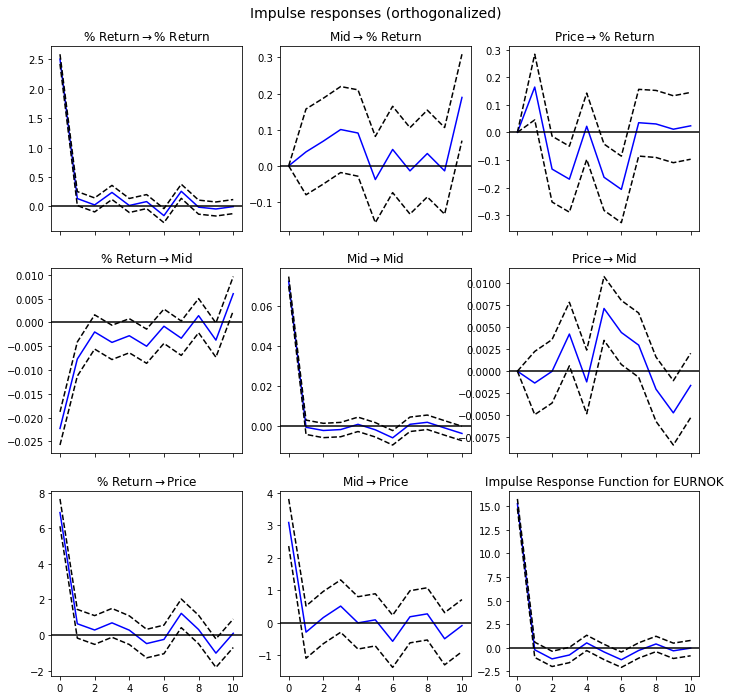

In [21]:
# Illustrating impulse response functions

irf = var_model.irf(10)
irf.plot(orth=True)
plt.title(f'Impulse Response Function for {ticker}')
plt.show()